### Step 1: Setup

#### 1.1 Import packages, define helper functions
For this tutorial, you will need `numpy`, `matplotlib`, `GPy`, `emukit`, `scipy` and `sklearn`.

Please make sure to have these packages installed using e.g. `pip`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import GPy

from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core import ParameterSpace, ContinuousParameter

from scipy.stats.qmc import Sobol

from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(123) # Set random seed for reproducibility

def scale_to_orig(x, bds): # Scales inputs to original domain
    res = np.zeros(x.shape)
    el_c = 0
    for el in x:
        for d in range(len(el)):
            res[el_c, d] = (bds[d][1] - bds[d][0]) * el[d] + bds[d][0]
        el_c += 1
    return res

#### 1.2 Define objective function for optimization
This is where one should supply their own function (FE simulation) along with:
- the dimensionality of the design space;
- the bounds of each considered parameter.

Make sure that the function takes a 2D-array as an input and returns a 2D-array as an output.
For simplicity, a (multi-dimensional) square function is taken as example.

In [3]:
def objective_function(x: np.ndarray) -> np.ndarray:
    return np.sum(x ** 2, axis=1)[:, None]

dim = 1
bds = [(-5, 10) for _ in range(dim)]

#### 1.3 Initial data

To select a "good" initial design of experiments, we will use Sobol sequence sampling.

In [4]:
sobolsamp = Sobol(d=dim, scramble=False)

n_DoE = 4 # Number of initial training inputs

X = scale_to_orig(sobolsamp.random(4), bds)
Y = objective_function(X)

Next, we introduce the "grid" data which we use to plot and predict the objective values at.

In [5]:
test_x_axes = [np.linspace(bds[k][0], bds[k][1], 300) for k in range(dim)]
test_x = np.meshgrid(*test_x_axes)
test_x_list = np.hstack([layer.reshape(-1, 1) for layer in test_x])

exact_y_list = objective_function(test_x_list)

Finally, all initial training (and testing) data is scaled appropriately.

In [6]:
scaler_X = StandardScaler()
scaler_X.fit(test_x_list)

scaler_Y = StandardScaler()
scaler_Y.fit(Y)

X_scaled = scaler_X.transform(X)
Y_scaled = scaler_Y.transform(Y)

test_x_list_scaled = scaler_X.transform(test_x_list)

#### 1.4 Acquisition optimizer setup
The acquisition function optimizer and the space which it should consider need to be specified:

In [7]:
space = ParameterSpace(
    [ContinuousParameter('x_%d' % i, min(test_x_list_scaled[:, i]), max(test_x_list_scaled[:, i])) for i in range(dim)]
)

optimizer = GradientAcquisitionOptimizer(space)

### Step 2: Optimization

#### 2.1 Optimization loop definition
Each optimization iteration consists of the following procedure:
1. GPR model is created given the available training data
2. Model is optimized
3. Acquisition function is specified
4. Acquisition is optimized; new input and outputs are evaluated 
5. The new data is merged with the old data, with the appropriate data scaling
6. The model is updated with the new training data set

As such, the `BO_loop` function takes the (scaled) training input and output sets and returns the updated (scaled) training and output sets, as well as the updated model.

In [8]:
def BO_loop(X_scaled, Y_scaled):
    gpy_model = GPy.models.GPRegression(X_scaled, Y_scaled, GPy.kern.RBF(dim))

    # gpy_model.likelihood.constrain_bounded(1e-10, 1) # Constrain noise level search space for likelihood maximization process
    # gpy_model.likelihood.fix(1e-10) # Fix noise level
    # gpy_model.optimize_restarts( # Optimize with restarts
    #     num_restarts=5,
    #     verbose=False,
    # )

    gpy_model.optimize() # Optimize with likelihood maximization

    emukit_model = GPyModelWrapper(gpy_model)

    ei_acquisition = ExpectedImprovement(emukit_model, jitter=0) # Expected improvement acquisition function
    # ei_list = ei_acquisition.evaluate(test_x_list_scaled)

    x_new_scaled, _ = optimizer.optimize(ei_acquisition)
    y_new = objective_function(scaler_X.inverse_transform(x_new_scaled))

    X_scaled = np.append(X_scaled, x_new_scaled, axis=0)
    Y_scaled = np.append(Y_scaled, scaler_Y.transform(y_new), axis=0)
    Y = scaler_Y.inverse_transform(Y_scaled)
    scaler_Y.fit(Y)
    Y_scaled = scaler_Y.transform(Y)

    emukit_model.set_data(X_scaled, Y_scaled)
    return X_scaled, Y_scaled, emukit_model

#### 2.2 Running the optimization loop
At this stage, the actual optimization is being performed.

In [9]:
n_iter = 10
for _ in range(n_iter):
    X_scaled, Y_scaled, emukit_model = BO_loop(X_scaled, Y_scaled)

 /home/leoguo/anaconda3/envs/GPenv/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/leoguo/anaconda3/envs/GPenv/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/leoguo/anaconda3/envs/GPenv/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


### 3 Post-processing
This is one possible routine to perform data post-processing, in which results are displayed on the fly, and no data is stored. It is encouraged to store the data appropriately in non-example problems. 

#### 3.1 History and predictive parameter collection for building the response surface

In [10]:
input_history = scaler_X.inverse_transform(X_scaled)
output_history = scaler_Y.inverse_transform(Y_scaled)

mu_plot, var_plot = emukit_model.predict(test_x_list_scaled)
mu_plot, var_plot = scaler_Y.inverse_transform(mu_plot), scaler_Y.inverse_transform(var_plot)

#### 3.2 Visualization

Initial DoE 
 [[-5.  ]
 [ 2.5 ]
 [ 6.25]
 [-1.25]]

Input iteration history 
 [[-1.24998855e+00]
 [-2.80950541e-01]
 [ 1.00000000e+01]
 [ 1.00303018e-03]
 [-4.62587397e-03]
 [ 3.20267617e-03]
 [-2.16412103e-02]
 [-2.62438592e-03]
 [ 2.97203241e-04]
 [-2.69440561e-03]]



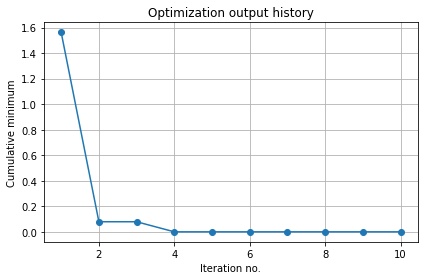

In [11]:
print('Initial DoE \n', input_history[:n_DoE]); print()
print('Input iteration history \n', input_history[n_DoE:]); print()

plt.figure()
plt.plot(range(1, 11), np.minimum.accumulate(output_history[4:]), '-o')
plt.xlabel('Iteration no.')
plt.ylabel('Cumulative minimum')
plt.title('Optimization output history')
plt.tight_layout()
plt.grid()

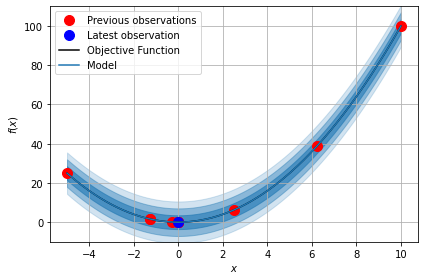

In [12]:
if dim == 1:
    plt.figure(figsize=(6, 4))
    plt.plot(input_history, output_history, "ro", markersize=10, label="Previous observations")
    plt.plot(input_history[-1], output_history[-1], "bo", markersize=10, label="Latest observation")
    plt.plot(test_x_list, exact_y_list, "k", label="Objective Function")
    plt.plot(test_x_list, mu_plot, "C0", label="Model")
    plt.fill_between(test_x_list[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    plt.fill_between(test_x_list[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    plt.fill_between(test_x_list[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    plt.legend(prop={'size': 10})
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.grid(True)
    c = (max(exact_y_list) - min(exact_y_list)) / 10
    plt.ylim([min(exact_y_list) - c, max(exact_y_list) + c])
    plt.tight_layout()